In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
file_path = "merged_CIC_IDS2017.csv"
df = pd.read_csv(file_path)

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2522362 entries, 0 to 2522361
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Fwd IAT Total                 int64  
 1    Fwd Avg Packets/Bulk         int64  
 2   FIN Flag Count                int64  
 3   Flow Bytes/s                  float64
 4   Fwd Avg Bytes/Bulk            int64  
 5    Packet Length Mean           float64
 6    Max Packet Length            int64  
 7    Flow IAT Min                 int64  
 8   Idle Mean                     float64
 9    Avg Bwd Segment Size         float64
 10   Init_Win_bytes_backward      int64  
 11   act_data_pkt_fwd             int64  
 12   Total Fwd Packets            int64  
 13   Fwd IAT Std                  float64
 14   Fwd IAT Min                  int64  
 15   Fwd Avg Bulk Rate            int64  
 16   Fwd IAT Mean                 float64
 17   min_seg_size_forward         int64  
 18   Active Min           

In [24]:
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Flow Bytes/s    353
dtype: int64


In [25]:
# Drop rows with missing values
df.dropna(inplace=True)

# Replace Infinite Values
df.replace([np.inf, -np.inf], 0, inplace=True)

#Drop Duplicated Columns
df = df.loc[:, ~df.columns.duplicated()]

print(f"Dataset after cleaning: {df.shape[0]} rows, {df.shape[1]} columns")


Dataset after cleaning: 2522009 rows, 79 columns


In [26]:
df.columns

Index(['Fwd IAT Total', ' Fwd Avg Packets/Bulk', 'FIN Flag Count',
       'Flow Bytes/s', 'Fwd Avg Bytes/Bulk', ' Packet Length Mean',
       ' Max Packet Length', ' Flow IAT Min', 'Idle Mean',
       ' Avg Bwd Segment Size', ' Init_Win_bytes_backward',
       ' act_data_pkt_fwd', ' Total Fwd Packets', ' Fwd IAT Std',
       ' Fwd IAT Min', ' Fwd Avg Bulk Rate', ' Fwd IAT Mean',
       ' min_seg_size_forward', ' Active Min', ' Bwd IAT Max', 'Fwd PSH Flags',
       ' Bwd IAT Std', ' PSH Flag Count', ' Bwd PSH Flags', ' Down/Up Ratio',
       ' Subflow Fwd Bytes', ' Active Max', 'Active Mean',
       ' Bwd Packet Length Min', ' Bwd IAT Min', ' Idle Min', ' Active Std',
       ' RST Flag Count', 'Bwd Packet Length Max', ' Destination Port',
       ' Idle Max', ' Bwd Avg Packets/Bulk', ' Fwd Header Length.1',
       ' Fwd Header Length', ' Fwd Packet Length Std', ' Min Packet Length',
       'Subflow Fwd Packets', ' Packet Length Variance', ' Flow IAT Max',
       'Bwd IAT Total', 'Bwd Avg

In [27]:
df.shape

(2522009, 79)

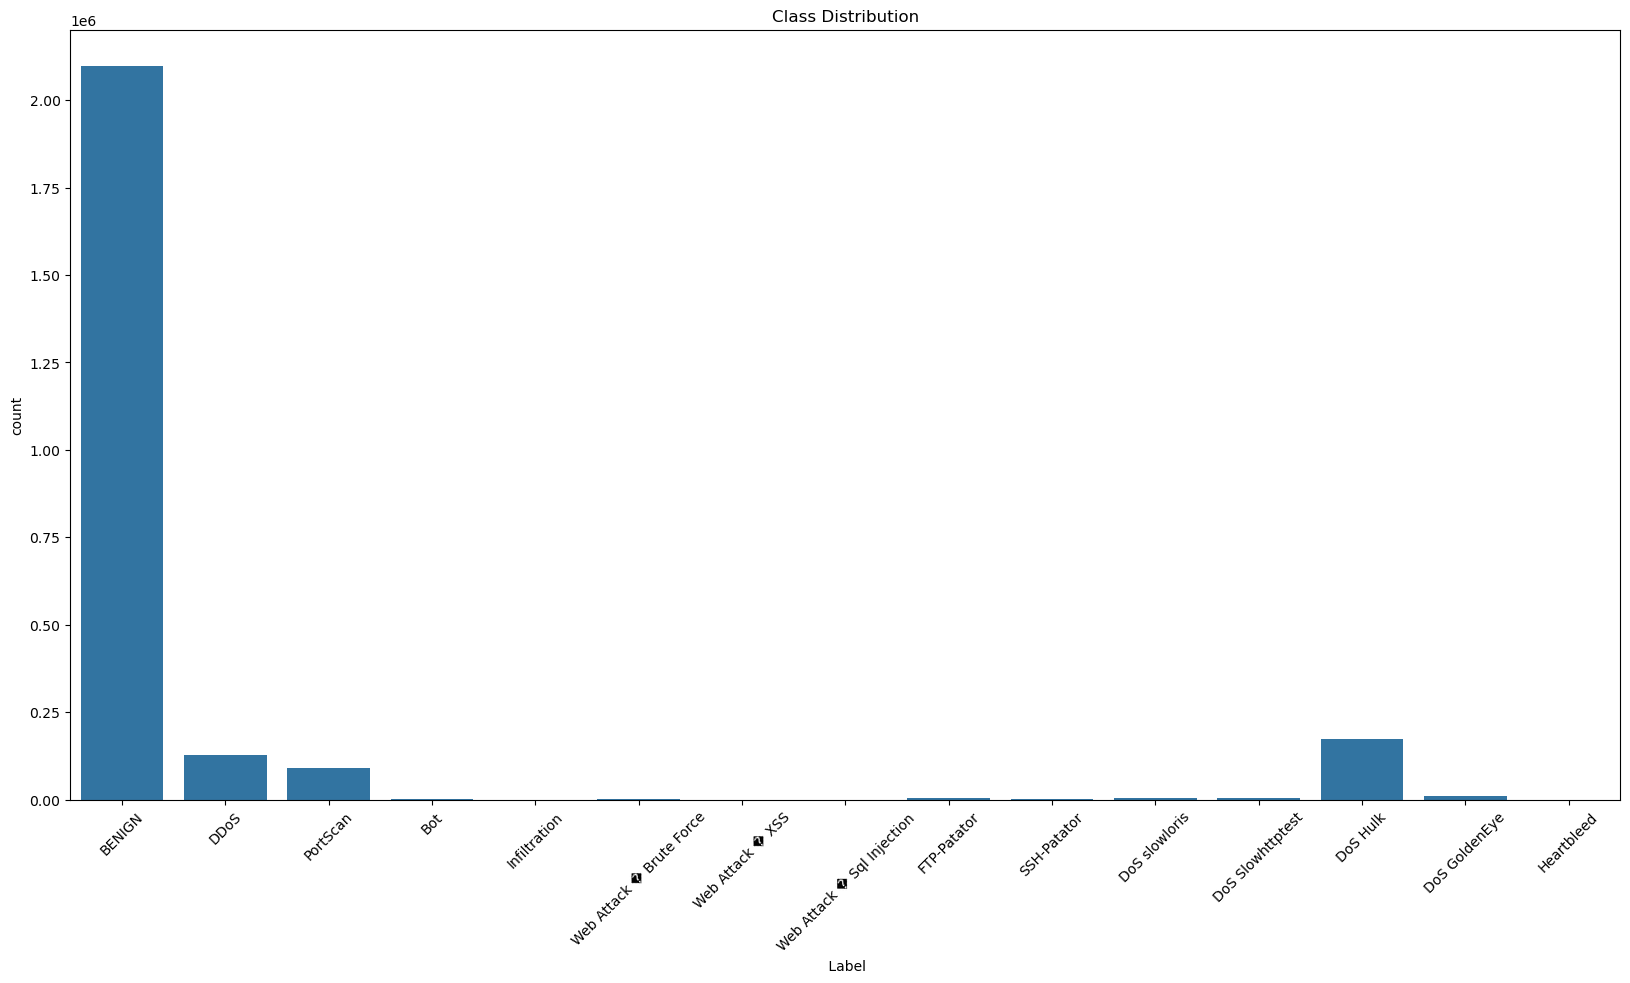

In [28]:
plt.figure(figsize=(20, 10))
sns.countplot(x=' Label', data=df)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [29]:
print(df[' Label'].value_counts())

 Label
BENIGN                        2096134
DoS Hulk                       172846
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [30]:
# Convert labels to binary (0 = Normal, 1 = Attack)
df[' Label'] = df[' Label'].apply(lambda x: 0 if x == "BENIGN" else 1)

# Check updated distribution
print(df[' Label'].value_counts())


 Label
0    2096134
1     425875
Name: count, dtype: int64


CORRELATION HEATMAP

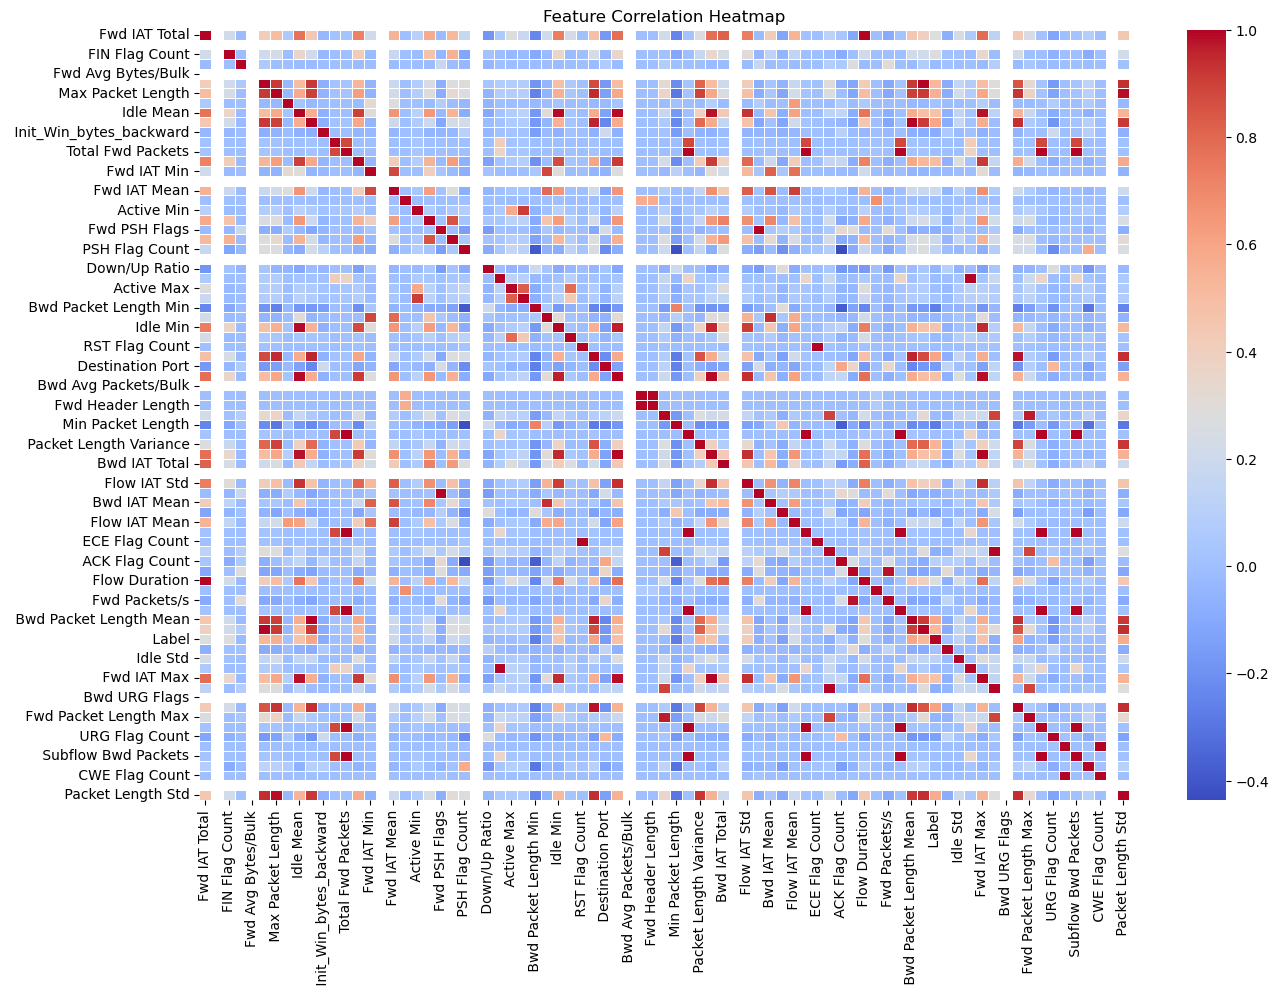

In [ ]:
# Remove non-numeric columns (e.g., 'Label' if it's categorical)
df_numeric = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [32]:
import numpy as np

# Compute Pearson correlation matrix
correlation_matrix = df.corr(method='pearson')

# Extract upper triangle of the correlation matrix (excluding diagonal)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find pairs with high correlation (absolute value > 0.9)
high_correlation_pairs = upper_triangle.stack().reset_index()
high_correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[abs(high_correlation_pairs['Correlation']) > 0.9]

# Display results
print(high_correlation_pairs)


                    Feature 1                Feature 2  Correlation
49              Fwd IAT Total            Flow Duration     0.998529
207        Packet Length Mean        Max Packet Length     0.916520
210        Packet Length Mean     Avg Bwd Segment Size     0.920909
257        Packet Length Mean   Bwd Packet Length Mean     0.920909
258        Packet Length Mean      Average Packet Size     0.997822
...                       ...                      ...          ...
2364   Bwd Packet Length Mean        Packet Length Std     0.918229
2379      Average Packet Size        Packet Length Std     0.943130
2456    Bwd Packet Length Std        Packet Length Std     0.941518
2466        Subflow Bwd Bytes      Subflow Bwd Packets     0.994424
2477            Fwd URG Flags           CWE Flag Count     1.000000

[71 rows x 3 columns]


In [33]:
# Find columns with correlation above 0.9
to_drop = [column for column in upper_triangle.columns if any(abs(upper_triangle[column]) > 0.9)]

# Drop the columns
df.drop(columns=to_drop, inplace=True)

print(f"Dropped {len(to_drop)} highly correlated features.")
print("Remaining features:", df.shape[1])


Dropped 30 highly correlated features.
Remaining features: 49


In [34]:
df.columns

Index(['Fwd IAT Total', ' Fwd Avg Packets/Bulk', 'FIN Flag Count',
       'Flow Bytes/s', 'Fwd Avg Bytes/Bulk', ' Packet Length Mean',
       ' Flow IAT Min', 'Idle Mean', ' Init_Win_bytes_backward',
       ' act_data_pkt_fwd', ' Total Fwd Packets', ' Fwd IAT Min',
       ' Fwd Avg Bulk Rate', ' Fwd IAT Mean', ' min_seg_size_forward',
       ' Active Min', ' Bwd IAT Max', 'Fwd PSH Flags', ' Bwd IAT Std',
       ' PSH Flag Count', ' Bwd PSH Flags', ' Down/Up Ratio',
       ' Subflow Fwd Bytes', ' Active Max', ' Bwd Packet Length Min',
       ' Bwd IAT Min', ' Active Std', ' RST Flag Count', ' Destination Port',
       ' Bwd Avg Packets/Bulk', ' Fwd Header Length.1',
       ' Fwd Packet Length Std', ' Min Packet Length',
       ' Packet Length Variance', 'Bwd IAT Total', 'Bwd Avg Bulk Rate',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' ACK Flag Count',
       ' Flow Packets/s', ' Bwd Header Length', ' Label', ' Bwd Packets/s',
       ' Idle Std', ' Bwd URG Flags', ' URG 

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Splitting data
X = df.drop(columns=[' Label'])
y = df[' Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model to check feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 20 Most Important Features:\n", feature_importances.head(20))

# OPTIONAL: Drop highly correlated features that have low importance (set threshold based on results)
low_importance_features = feature_importances[feature_importances < 0.01].index.tolist()
df.drop(columns=low_importance_features, inplace=True)

print(f"Dropped {len(low_importance_features)} low-importance features after feature selection.")
print("Remaining features:", df.shape[1])



Top 20 Most Important Features:
  Packet Length Variance     0.137261
 Packet Length Mean         0.097135
 Destination Port           0.068801
 Total Fwd Packets          0.049151
 Subflow Fwd Bytes          0.043669
Idle Mean                   0.042939
 Flow Packets/s             0.041758
 Fwd Header Length.1        0.039413
 Fwd IAT Mean               0.039070
 Fwd Packet Length Mean     0.035882
 Bwd Packets/s              0.031930
 Init_Win_bytes_backward    0.031059
Fwd IAT Total               0.028938
Init_Win_bytes_forward      0.028270
 PSH Flag Count             0.025297
 Bwd Packet Length Min      0.025088
 min_seg_size_forward       0.022405
 Bwd Header Length          0.020379
 Min Packet Length          0.019898
 ACK Flag Count             0.018199
dtype: float64
Dropped 22 low-importance features after feature selection.
Remaining features: 27


In [36]:
from sklearn.feature_selection import VarianceThreshold

# Exclude the label column
X = df.drop(columns=[' Label'], errors='ignore')  

# Initialize variance threshold selector
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold if needed

# Fit the selector to the dataset
selector.fit(X)

# Get feature names with low variance
low_variance_features = X.columns[~selector.get_support()]

print(f"Features with near-zero variance:\n{low_variance_features}")


Features with near-zero variance:
Index([], dtype='object')


In [37]:
df= df.drop(columns=low_variance_features, errors='ignore')

print(f"Shape after dropping near-zero variance features: {df.shape}")


Shape after dropping near-zero variance features: (2522009, 27)


In [38]:
df_cleaned = df.loc[:, ~df.columns.duplicated()]
print(f"Shape after removing duplicate columns: {df_cleaned.shape}")


Shape after removing duplicate columns: (2522009, 27)


In [39]:
# Check if any missing values exist
print("Missing values per column:\n", df_cleaned.isnull().sum())

# Replace infinite values with large finite numbers
df_cleaned.replace([float('inf'), -float('inf')], 0, inplace=True)


Missing values per column:
 Fwd IAT Total               0
Flow Bytes/s                0
 Packet Length Mean         0
Idle Mean                   0
 Init_Win_bytes_backward    0
 act_data_pkt_fwd           0
 Total Fwd Packets          0
 Fwd IAT Min                0
 Fwd IAT Mean               0
 min_seg_size_forward       0
 Active Min                 0
 PSH Flag Count             0
 Subflow Fwd Bytes          0
 Bwd Packet Length Min      0
 Destination Port           0
 Fwd Header Length.1        0
 Fwd Packet Length Std      0
 Min Packet Length          0
 Packet Length Variance     0
 Fwd Packet Length Min      0
 Fwd Packet Length Mean     0
 ACK Flag Count             0
 Flow Packets/s             0
 Bwd Header Length          0
 Label                      0
 Bwd Packets/s              0
Init_Win_bytes_forward      0
dtype: int64


In [40]:
df_cleaned.to_csv("cleaned_CIC_IDS2017.csv", index=False)
print("Final cleaned dataset saved as 'cleaned_CIC_IDS2017.csv'")


Final cleaned dataset saved as 'cleaned_CIC_IDS2017.csv'


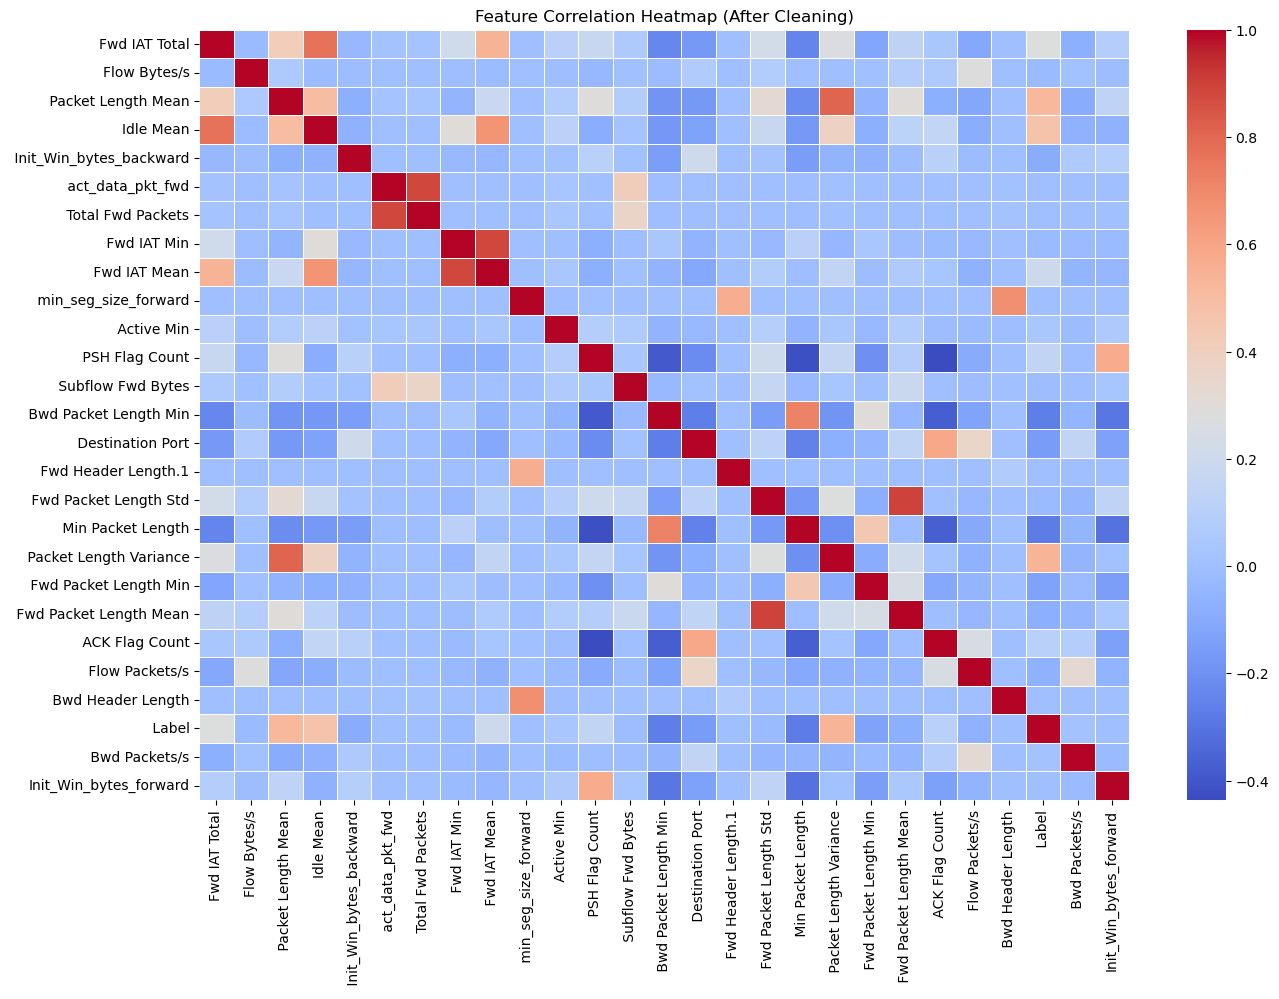

In [41]:
# Correlation Heatmap (After Cleaning)
plt.figure(figsize=(15, 10))
sns.heatmap(df_cleaned.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap (After Cleaning)")
plt.show()
